In [69]:
import os
import argparse
import numpy as np
import pandas as pd
import datetime as dt

#bt_dir = '../adr_results/1400_1e-4_var_penalty_from_2021'
bt_dir = '../adr_results/1e-4_all_europe_pos_constraint_1430_2pct_exclusions/'

pnl = pd.read_csv(os.path.join(bt_dir, 'pnl.csv', ), index_col=0, parse_dates=True)
pnl.columns = ['pnl']
gmv = pd.read_csv(os.path.join(bt_dir, 'gmv.csv'), index_col=0, parse_dates=True)
gmv.columns = ['gmv']
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['commission'] = 0.0006 * trade_df['size'].abs()
close_idx = trade_df['timestamp'].str[11:13] == '16'
trade_df.loc[close_idx, 'exchange_fee'] = 0.0016 * trade_df.loc[close_idx, 'size'].abs()
trade_df.loc[~close_idx, 'exchange_fee'] = -0.0018 * trade_df.loc[~close_idx, 'size'].abs()
trade_df['date'] = pd.to_datetime(trade_df['timestamp'].str[:10])

In [70]:
daily_fees = trade_df.groupby('date')[['commission', 'exchange_fee']].sum()
merged = pnl.merge(daily_fees, left_index=True, right_index=True)
merged['pnl_after_fees'] = merged['pnl'] - merged['commission'] - merged['exchange_fee']
merged = merged.merge(gmv, left_index=True, right_index=True)

In [71]:
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df = trade_df[trade_df['timestamp']<='2025-11-07']
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True, format='mixed')
trades = trade_df.groupby(['timestamp','ticker']).last().reset_index()
trades['pos'] = trades.groupby('ticker')['size'].transform('cumsum')
pos = trades.pivot(index='timestamp',columns='ticker',values='pos').ffill().fillna(0)
price = trades.pivot(index='timestamp',columns='ticker',values='price').ffill().fillna(0)
all_gmv = (pos * price).abs().sum(axis=1)
max_gmv = all_gmv.max()

In [72]:
mean_gmv = all_gmv.resample('1min').min().mean()

Text(0.95, 0.7, 'Total PnL: $7,548,000\nAnnualized PnL: 1,511,000\nAnnualized Return on Capital: 52.61%\nAnnualized Sharpe: 6.61\n')

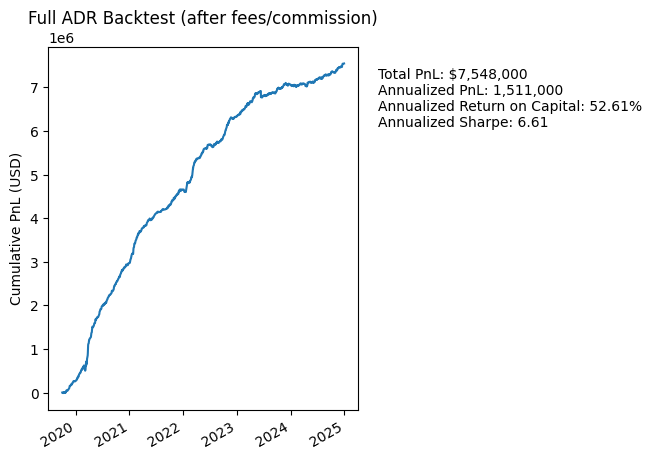

In [73]:
import matplotlib.pyplot as plt
merged = merged.loc[:'2025-11-07']
all_gmv = all_gmv.loc[:'2025-11-07']
all_gmv = all_gmv.to_frame(name='gmv')
all_gmv['date'] = all_gmv.index.date
gmv_merged = pnl.merge(all_gmv.loc['2019':'2024'].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
annualized_ret = (gmv_merged['pnl']/gmv_merged['gmv']).mean() * 252 * 100/15


plt.figure(figsize=(4,4*1.333))
merged.loc['2019':'2024'].loc['2019':'2024', 'pnl_after_fees'].cumsum().plot()
plt.title('Full ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2019':'2024']['pnl_after_fees'].sum().round(-3):,.0f}\n"
                        f"Annualized PnL: {(252 * merged.loc['2019':'2024']['pnl_after_fees'].sum() / len(merged.loc['2019':'2024'])).round(-3):,.0f}\n"
                        f"Annualized Return on Capital: {annualized_ret:.2%}\n"
                       f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2019':'2024']['pnl_after_fees'].mean()/merged.loc['2019':'2024']['pnl_after_fees'].std():.2f}\n")

Text(0.95, 0.7, 'Total PnL: $723,000\nAnnualized PnL: 884,000\nAnnualized Return: 27.84%\nAnnualized Sharpe: 4.08\n')

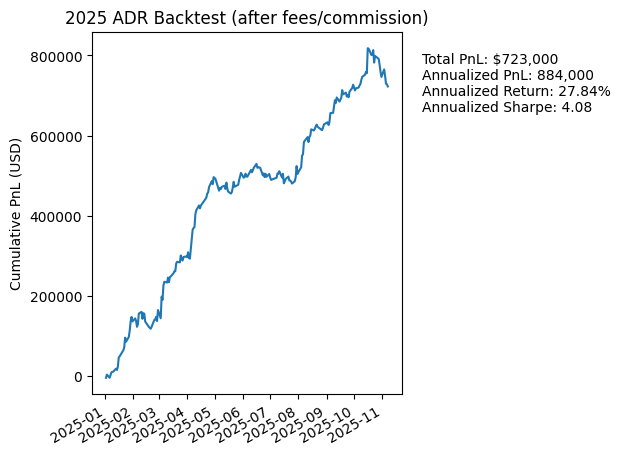

In [74]:
import matplotlib.pyplot as plt

#all_gmv = all_gmv.to_frame(name='gmv')
all_gmv['date'] = all_gmv.index.date
gmv_merged = pnl.merge(all_gmv.loc['2025':].groupby('date')['gmv'].max().to_frame(name='gmv'), left_index=True, right_index=True)
annualized_ret = (gmv_merged['pnl']/gmv_merged['gmv']).mean() * 252 * 100/15

plt.figure(figsize=(4,4*1.333))
merged.loc['2025':, 'pnl_after_fees'].cumsum().plot()

plt.title('2025 ADR Backtest (after fees/commission)')
plt.ylabel('Cumulative PnL (USD)')
# Displaying metrics in whitespace outside of plot, with commas as thousands separators:
plt.figtext(.95, 0.7, f"Total PnL: ${merged.loc['2025':]['pnl_after_fees'].sum().round(-3):,.0f}\n"
                        f"Annualized PnL: {(252 * merged.loc['2025':]['pnl_after_fees'].sum() / len(merged.loc['2025':])).round(-3):,.0f}\n"
                        f"Annualized Return: {annualized_ret:.2%}\n"
                       f"Annualized Sharpe: {np.sqrt(252) * merged.loc['2025':]['pnl_after_fees'].mean()/merged.loc['2025':]['pnl_after_fees'].std():.2f}\n")

In [7]:
import os
import pandas as pd

price_filename = '../data/raw/adrs/adr_PX_LAST_adjust_none.csv'
etf_filename = '../data/raw/etfs/market/market_etf_PX_LAST_adjust_none.csv'
trade_df = pd.read_csv(os.path.join(bt_dir, 'trades.csv'))
trade_df['timestamp'] = pd.to_datetime(trade_df['timestamp'], utc=True)

price_df = pd.read_csv(price_filename, index_col=0, parse_dates=True)
etf_df = pd.read_csv(etf_filename, index_col=0, parse_dates=True)
price_df = pd.concat([price_df, etf_df], axis=1)
trade_df['date'] = trade_df['timestamp'].dt.date

position_df = trade_df[['date','ticker','size']].groupby(['date','ticker'])['size'].sum().unstack().fillna(0).cumsum()
notional_trade_df = trade_df.copy()
notional_trade_df['value'] = notional_trade_df['size'] * notional_trade_df['price']

cash_flow = -notional_trade_df.groupby(['date','ticker'])['value'].sum()
    
position_change = position_df.diff()
position_change.iloc[0] = position_df.iloc[0]
position_value = (position_df * price_df.loc[position_df.index, position_df.columns])

pnl = (position_value - position_value.shift(fill_value=0)) + cash_flow
gmv = position_value.abs()

NameError: name 'by_ticker' is not defined

In [9]:
by_ticker = cash_flow.unstack()
by_ticker.index = pd.to_datetime(by_ticker.index)


In [12]:
by_ticker.loc['2025':].sum().sort_values()

ticker
GMAB     -76738.5750
SAP      -62722.3000
EWU      -52721.4950
UBS      -49107.3150
ARGX     -44001.5750
RYAAY    -39608.2250
RTO      -37162.1900
ASML     -30656.9900
DEO      -28854.4600
TS       -17769.6900
E        -14632.8250
WPP       -8414.3350
NOK       -7393.0150
BUD       -3123.1200
PHG        1648.6450
BP         2728.1850
TTE        4871.8747
UL         6845.1550
SNN        6914.3750
IHG        8607.4250
EQNR      13412.8500
HSBC      14160.0550
RIO       15008.4900
AZN       15290.2700
ERIC      15955.4950
PUK       17000.5850
NVS       19156.2000
PSO       21617.0950
ING       23313.5050
BTI       23495.7200
BCS       32309.6850
VOD       33095.4150
SHEL      34783.3200
GSK       35616.1700
SNY       39069.7100
RELX      39640.8550
FMS       47383.0800
NGG       48593.1300
NWG       56481.9000
AEG       58185.9350
SAN       66427.8050
NVO       69937.8100
DB        81664.2450
BBVA      96701.1300
HLN      104550.1000
FEZ      107227.6650
LYG      110652.9400
dtype:

In [28]:
by_ticker['GSK'].sort_values()

date
2020-03-13   -78528.450
2020-03-16   -51222.915
2020-03-18   -30338.820
2025-05-06   -30247.900
2022-08-11   -22997.315
                ...    
2020-03-10    56398.500
2020-03-19    60780.660
2022-07-19          NaN
2022-07-20          NaN
2022-07-21          NaN
Name: GSK, Length: 1408, dtype: float64

In [29]:
open_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).first().reset_index()
open_df['val'] = open_df['size'] * open_df['price']
open_df['val'].sort_values()


20623   -1.285021e+07
20455   -1.078317e+07
20817   -1.050231e+07
21435   -1.009293e+07
20290   -1.002881e+07
             ...     
20173    8.995683e+06
20723    9.325432e+06
20754    9.937811e+06
20561    1.087597e+07
21002    1.545637e+07
Name: val, Length: 63050, dtype: float64

In [30]:
trade_df['date']

0         2019-10-02
1         2019-10-02
2         2019-10-02
3         2019-10-02
4         2019-10-02
             ...    
126095    2025-12-09
126096    2025-12-09
126097    2025-12-09
126098    2025-12-09
126099    2025-12-09
Name: date, Length: 126100, dtype: object

In [31]:
trade_df[(trade_df['ticker']=='GSK') & (trade_df['timestamp'].dt.strftime('%Y-%m-%d')=='2024-10-09')]

,timestamp,ticker,size,price,date
101288,2024-10-09 14:00:00+00:00,GSK,-35726,40.985,2024-10-09
101289,2024-10-09 16:00:00+00:00,GSK,35726,40.240,2024-10-09


In [32]:
close_df = trade_df.sort_values('timestamp').groupby(['ticker','date']).last().reset_index()
prices = close_df[['date','ticker','price']].merge(open_df[['date','ticker','price']], on=['date','ticker'], suffixes=('_close','_open'))
prices['date'] = pd.to_datetime(prices['date']).dt.strftime('%Y-%m-%d')
((prices['price_open'] - prices['price_close'])>0).sum()/len(prices)

0.48791435368754954

In [33]:
prices[prices['date'] == '2024-10-09']

,date,ticker,price_close,price_open
1143,2024-10-09,AEG,6.240,6.225
2514,2024-10-09,ARGX,520.520,518.575
3883,2024-10-09,ASML,845.900,840.565
5282,2024-10-09,AZN,77.505,77.320
6690,2024-10-09,BBVA,10.150,10.165
8098,2024-10-09,BCS,12.190,12.215
9475,2024-10-09,BP,31.980,32.025
10851,2024-10-09,BTI,35.480,35.465
12259,2024-10-09,BUD,64.270,64.370
13667,2024-10-09,DB,17.500,17.495


In [34]:
open_df

,ticker,date,timestamp,size,price,val
0,AEG,2019-10-02,2019-10-02 14:00:00+00:00,16794,3.975,66756.150
1,AEG,2019-10-04,2019-10-04 14:00:00+00:00,13229,4.035,53379.015
2,AEG,2019-10-07,2019-10-07 14:00:00+00:00,15209,4.085,62128.765
3,AEG,2019-10-08,2019-10-08 14:00:00+00:00,33453,3.985,133310.205
4,AEG,2019-10-09,2019-10-09 14:00:00+00:00,19393,3.995,77475.035
...,...,...,...,...,...,...
63045,WPP,2025-12-03,2025-12-03 14:00:00+00:00,10081,18.545,186952.145
63046,WPP,2025-12-04,2025-12-04 14:00:00+00:00,-4794,19.470,-93339.180
63047,WPP,2025-12-05,2025-12-05 14:00:00+00:00,12915,19.490,251713.350
63048,WPP,2025-12-08,2025-12-08 14:00:00+00:00,-7917,19.970,-158102.490


In [35]:
by_ticker

ticker,AEG,ARGX,ASML,AZN,BBVA,BCS,BP,BTI,BUD,DB,...,SAP,SHEL,SNN,SNY,TS,TTE,UBS,UL,VOD,WPP
date,,,,,,,,,,,,,,,,,,,,,
2019-10-02,83.970,NaN,NaN,3626.985,-494.715,119.890,NaN,NaN,-14.420,274.650,...,18.850,NaN,-661.675,NaN,2176.515,NaN,-3247.200,-1185.200,NaN,7.140
2019-10-04,66.145,NaN,NaN,2730.640,-1018.815,-1813.275,NaN,NaN,-2914.000,-1143.800,...,456.680,NaN,-489.825,NaN,-100.760,NaN,882.000,-1973.985,NaN,224.640
2019-10-07,-684.405,NaN,NaN,-4995.630,535.800,913.360,NaN,NaN,-4007.960,1586.250,...,-609.840,NaN,-546.650,NaN,-1981.980,NaN,-1267.825,1916.400,NaN,186.200
2019-10-08,-1170.855,NaN,NaN,60.375,-499.935,713.750,NaN,NaN,605.605,899.175,...,-7362.520,NaN,-1195.635,NaN,1269.960,NaN,-480.150,-2140.050,NaN,299.980
2019-10-09,96.965,NaN,NaN,-297.435,141.600,-172.390,NaN,NaN,1393.875,-215.915,...,2939.040,NaN,-489.685,NaN,358.085,NaN,580.825,369.600,NaN,19.180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-03,-357.915,-1524.400,-1726.300,171.900,193.430,-1490.085,555.295,-1349.460,2350.080,1865.625,...,-3806.970,4442.935,-259.350,-10.885,-856.500,-996.4800,954.975,55.400,1270.950,3477.945
2025-12-04,1418.575,455.860,-2222.410,5151.375,-42.985,2667.015,-144.075,688.940,-1078.345,-1140.360,...,5032.850,-3082.460,-278.920,-2881.005,1568.000,-5.4009,-1550.745,-243.865,1004.125,767.040
2025-12-05,177.630,-1075.125,-3602.425,-1442.850,-719.145,-57.885,918.385,7073.775,-36.875,-644.385,...,-1322.875,-8320.400,883.845,961.450,82.775,5.1800,-981.695,3536.820,249.430,-2066.400


/tmp/ipykernel_806957/2491717829.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)


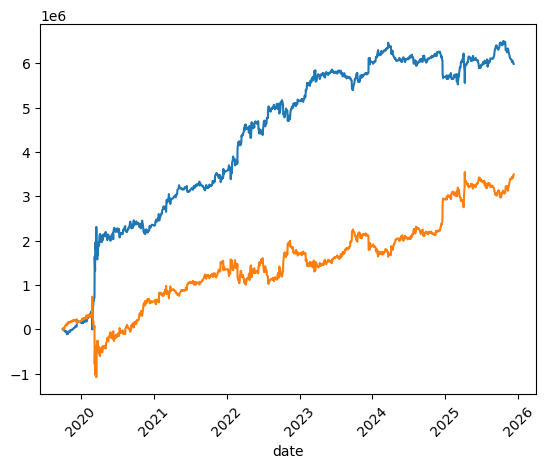

In [36]:
open_df['sign']=(open_df['val']>0)
sign_df = open_df.pivot(index='date', columns='ticker', values='sign').fillna(0).astype(int)
long_pnl = (sign_df * by_ticker).sum(axis=1)
short_pnl = ((1-sign_df) * by_ticker).sum(axis=1)

long_pnl.cumsum().plot(label='Long PnL')
short_pnl.cumsum().plot(label='Short PnL')
plt.xticks(rotation=45);

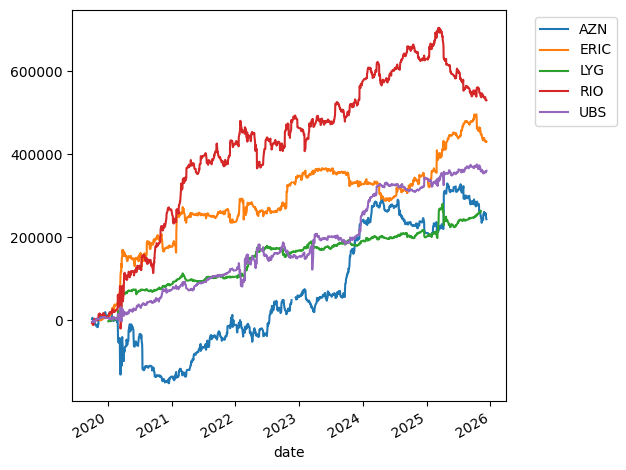

In [66]:
by_ticker[['AZN','ERIC','LYG','RIO','UBS']].cumsum().plot()
#plt.ylim([-500000,500000])
# putting legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

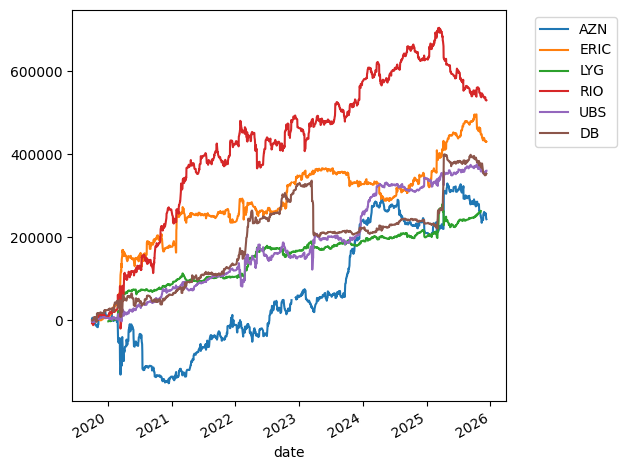

In [67]:
by_ticker[['AZN','ERIC','LYG','RIO','UBS','DB']].cumsum().plot()
#plt.ylim([-500000,500000])
# putting legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

In [ ]:
ticker = 'DB'
db_df = pd.read_parquet('../data/raw/adrs/bbo-1m/nbbo/ticker=DB')
db_df.loc['2025-10-09 13:30:00'][['nbbo_bid','nbbo_ask','nbbo_bid_sz','nbbo_ask_sz']]

nbbo_bid       35.04
nbbo_ask       35.05
nbbo_bid_sz     1500
nbbo_ask_sz      441
Name: 2025-10-09 13:30:00-04:00, dtype: object

In [ ]:
ret_sign = trade_df.sort_values('timestamp').groupby(['date','ticker'])['price'].apply(lambda x: np.sign(x.iloc[-1]-x.iloc[0]))
trade_sign = np.sign(trade_df.sort_values('timestamp').groupby(['date','ticker'])['size'].first())
trade_sign

date        ticker
2023-07-20  AEG      -1
            ARGX      1
            ASML      1
            AZN       1
            BBVA     -1
                     ..
2025-11-04  TS       -1
            TTE       1
            UL       -1
            VOD       1
            WPP       1
Name: size, Length: 22150, dtype: int64

0.5110609480812641